# Real atoms in a MOT

This example covers calculating the forces in various type-I and type-II
three-dimensional MOT with real atoms and comparing the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp

### $^7$Li: compare the D$_2$ line with a basic $F=2\rightarrow F=3$ transition

We'll do this specifically for $^7$Li.  As usual, we first define the Hamiltonian, laser Beams, and magnetic field.  We start with the full D$_2$ line.  Note that we need to specify a repump laser, which, for $^7$Li, generally has the same red detuning as the main cooling beam.

In [2]:
det = -2.0
alpha = 1.0
beta = 1.0

# Define the atomic Hamiltonian for 7Li:
atom = pylcp.atom("7Li")
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)

# Now, we need to sets of laser beams -> one for F=1->2 and one for F=2->3:
laserBeams_cooling_D2 = pylcp.tools.standard_six_beam_MOT(
    beta, (E_e_D2[0] - E_g_D2[1]) + det)
laserBeams_repump_D2 = pylcp.tools.standard_six_beam_MOT(
    beta, (E_e_D2[1] - E_g_D2[0]) + det)
laserBeams_D2 = laserBeams_cooling_D2 + laserBeams_repump_D2

Construct the rate equations for the full D$_2$ line and calculate a force profile:

In [2]:
x = np.arange(-5, 5.1, 0.2)
v = np.arange(-5, 5.1, 0.2)

X, V = np.meshgrid(x, v)

# Define the trap:
trap_D2 = pylcp.rateeq(
    laserBeams_D2, lambda R: pylcp.tools.quadrupoleField3D(R, alpha), hamiltonian_D2, include_mag_forces=False)
trap_D2.generate_force_profile(
    [np.zeros(X.shape), np.zeros(X.shape), X],
    [np.zeros(V.shape), np.zeros(V.shape), V],
    name='Fz')
FzLi_D2 = trap_D2.profile['Fz'].F[2]

Now, repeat the same procedure for the simpler $F=2\rightarrow F'=3$ transition, making sure we keep the g-factors the same:

In [2]:
# Define the atomic Hamiltonian for F-> 2 to 3:
H_g_23, mu_q_g_23 = pylcp.hamiltonians.singleF(F=2, gF=1/2, muB=1)
H_e_23, mu_q_e_23 = pylcp.hamiltonians.singleF(F=3, gF=2/3, muB=1)

dijq_23 = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)

hamiltonian_23 = pylcp.hamiltonian(H_g_23, H_e_23, mu_q_g_23, mu_q_e_23, dijq_23)

# Define the laser beams for 2->3
laserBeams_23 = pylcp.tools.standard_six_beam_MOT(beta, det)

# Make the trap for 2->3
trap_23 = pylcp.rateeq(
    laserBeams_23, lambda R: pylcp.tools.quadrupoleField3D(R, alpha), hamiltonian_23, include_mag_forces=False)
trap_23.generate_force_profile(
    [np.zeros(X.shape), np.zeros(X.shape), X],
    [np.zeros(V.shape), np.zeros(V.shape), V],
    name='Fz')
Fz2to3 = trap_23.profile['Fz'].F[2]
trap_23.profile['Fz'].Neq

Plot up the results:

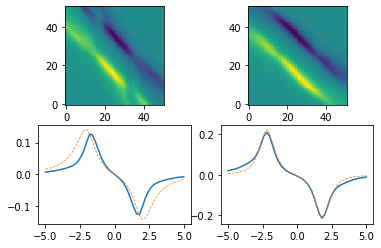

In [2]:
# Plot up the results:
fig, ax = plt.subplots(2, 2, num="7Li D2 line MOT axial forces")
ax[0, 0].imshow(FzLi_D2, origin='bottom')
ax[0, 1].imshow(Fz2to3, origin='bottom')
ax[1, 0].plot(X[int(X.shape[0]/2), :], FzLi_D2[int(X.shape[0]/2), :])
ax[1, 0].plot(X[int(X.shape[0]/2), :], Fz2to3[int(X.shape[0]/2), :], '--',
              linewidth=0.75)
ax[1, 1].plot(V[:, int(X.shape[1]/2)+1], FzLi_D2[:, int(X.shape[1]/2)+1])
ax[1, 1].plot(V[:, int(X.shape[1]/2)+1], Fz2to3[:, int(X.shape[1]/2)+1], '--',
              linewidth=0.75)

Now, it seems to me that because of the un-resolved hyperfine structure in the
excited state that is inherent in 7Li, the repump, which drives $F=1\rightarrow F'=2$
transitions will also contribute the trapping and cause most of the difference
between the $F=2\rightarrow F=3$ and the full Hamiltonian calculation.  

### Switch to $^{87}$Rb

By switching to 87Rb we can bring the repump to resonance, and turn down its intensity to 1/10 of the main cooling light.

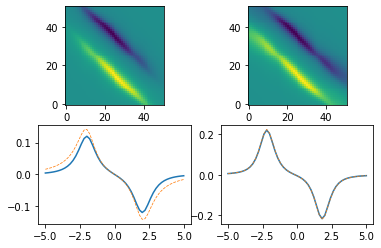

In [3]:
atom = pylcp.atom("87Rb")
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)
mu_q_g_D2[1]
dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)

# Now, we need to sets of laser beams -> one for F=1->2 and one for F=2->3:
laserBeams_cooling_D2 = pylcp.tools.standard_six_beam_MOT(
    beta, (E_e_D2[-1] - E_g_D2[-1]) + det)
laserBeams_repump_D2 = pylcp.tools.standard_six_beam_MOT(
    0.01*beta, (E_e_D2[-2] - E_g_D2[-2]))
laserBeams_D2 = laserBeams_cooling_D2 + laserBeams_repump_D2

trap_D2 = pylcp.trap_rateeq(
    laserBeams_D2, lambda R: pylcp.tools.quadrupoleField3D(R, alpha), hamiltonian_D2, include_mag_forces=False)
trap_D2.generate_force_profile(
    [np.zeros(X.shape), np.zeros(X.shape), X],
    [np.zeros(V.shape), np.zeros(V.shape), V],
    name='Fz')
FzRb_D2 = trap_D2.profile['Fz'].F[2]

# Plot up the results:
fig, ax = plt.subplots(2, 2, num="87Rb D2 line MOT axial forces")
ax[0, 0].imshow(FzRb_D2, origin='bottom')
ax[0, 1].imshow(Fz2to3, origin='bottom')
ax[1, 0].plot(X[int(X.shape[0]/2), :], FzRb_D2[int(X.shape[0]/2), :])
ax[1, 0].plot(X[int(X.shape[0]/2), :], Fz2to3[int(X.shape[0]/2), :], '--',
              linewidth=0.75)
ax[1, 1].plot(V[:, int(X.shape[1]/2)+1], FzRb_D2[:, int(X.shape[1]/2)+1])
ax[1, 1].plot(V[:, int(X.shape[1]/2)+1], Fz2to3[:, int(X.shape[1]/2)+1], '--',
              linewidth=0.75)

### $^{23}$Na: type-I MOTs

Now let's cover the four type I (type-I/type-II) MOTs of J. Flemming, et. al.,
Opt. Commun. 135, 269 (1997).

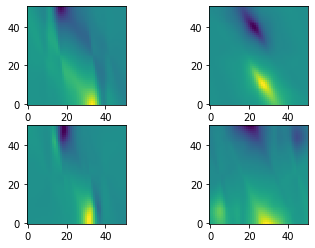

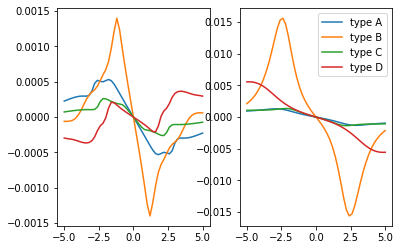

In [4]:
atom = pylcp.atom("23Na")
H_g_D1, Bq_g_D1 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[1].gammaHz, Bhfs=0, Chfs=0,
    muB=3)
H_e_D1, Bq_e_D1 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[1].J, atom.I, atom.state[1].gJ, atom.gI,
    Ahfs=atom.state[1].Ahfs/atom.state[1].gammaHz,
    Bhfs=atom.state[1].Bhfs/atom.state[1].gammaHz, Chfs=0,
    muB=3)

E_g_D1 = np.unique(np.diagonal(H_g_D1))
E_e_D1 = np.unique(np.diagonal(H_e_D1))

dijq_D1 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[1].J, atom.I)

hamiltonian_D1 = pylcp.hamiltonian(H_g_D1, H_e_D1, Bq_g_D1, Bq_e_D1, dijq_D1)

# Conditions taken from the paper, Table 1:
conds = np.array([[1, 1, -25/10, -1, 2, 1, -60/10, +1],
                  [1, 1, -20/10, -1, 2, 2, -30/10, +1],
                  [1, 2, -20/10, +1, 2, 1, -50/10, +1],
                  [1, 2, -40/10, +1, 2, 2, -60/10, +1]])

FzNa_D1 = np.zeros((4,) + FzRb_D2.shape)
for ii, cond in enumerate(conds):
    laserBeams_laser1 = pylcp.tools.standard_six_beam_MOT(
        beta, (E_e_D1[int(cond[1]-1)] - E_g_D1[0]) + cond[2], pol=cond[3])
    laserBeams_laser2 = pylcp.tools.standard_six_beam_MOT(
        beta, (E_e_D1[int(cond[5]-1)] - E_g_D1[1]) + cond[6], pol=cond[7])
    laserBeams_D1 = laserBeams_laser1 + laserBeams_laser2

    # Calculate the forces:
    trap_D1 = pylcp.trap_rateeq(
        laserBeams_D1, lambda R: pylcp.tools.quadrupoleField3D(R, alpha),
        hamiltonian_D1, include_mag_forces=False)
    trap_D1.generate_force_profile(
        [np.zeros(X.shape), np.zeros(X.shape), X],
        [np.zeros(V.shape), np.zeros(V.shape), V],
        name='Fz')
    FzNa_D1[ii] = trap_D1.profile['Fz'].F[2]

# Plot up the results:
lim = np.amax(np.abs(FzNa_D1))
fig, ax = plt.subplots(2, 2, num="23Na D1 line MOTs axial forces")
ax[0, 0].imshow(FzNa_D1[0], origin='bottom')
ax[0, 1].imshow(FzNa_D1[1], origin='bottom')
ax[1, 0].imshow(FzNa_D1[2], origin='bottom')
ax[1, 1].imshow(FzNa_D1[3], origin='bottom')

fig, ax = plt.subplots(1, 2, num="23Na D1 line MOTs axial force v=0/z=0")
types = ['A','B','C','D']
for ii in range(4):
    ax[0].plot(x,FzNa_D1[ii][int(len(x)/2),:], label='type ' + types[ii])
    ax[1].plot(v,FzNa_D1[ii][:,int(len(v)/2)], label='type ' + types[ii])
ax[1].legend()